In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from sklearn import linear_model
import pwlf

# Assumptions

In [2]:
DEATH_RATE = 0.01
ICU_RATE = 0.05
HOSPITAL_RATE = 0.15
SYMPTOM_RATE = 0.2
INFECT_2_HOSPITAL_TIME = 13
HOSPITAL_2_ICU_TIME = 2
ICU_2_DEATH_TIME = 5
ICU_2_RECOVER_TIME = 11
NOT_ICU_DISCHARGE_TIME = 7

In [3]:
avg_icu_time = int(np.round((ICU_2_DEATH_TIME*DEATH_RATE + ICU_2_RECOVER_TIME*(ICU_RATE-DEATH_RATE))/ICU_RATE, 0)) 
#(included both dead (5) and alive(11)): (5+11*4)/5
# Only ICU (critical) can develop death
avg_hospital_time = int(np.round(((HOSPITAL_2_ICU_TIME+ICU_2_DEATH_TIME)*DEATH_RATE+
                                  (HOSPITAL_2_ICU_TIME+ICU_2_RECOVER_TIME+NOT_ICU_DISCHARGE_TIME)*(ICU_RATE-DEATH_RATE)+
                                  NOT_ICU_DISCHARGE_TIME*(HOSPITAL_RATE-ICU_RATE))/HOSPITAL_RATE))
#Average hospital time is 10 (assume 7 days discharge if not in ICU or come back from ICU): ((2+5)+(2+11+7)*4)+7*10)/15

# Data

In [4]:
def get_global_death_data(csv_file='../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'):
    death_data = pd.read_csv(csv_file)
    return death_data.rename(index=str, columns={"Country/Region": "Country", "Province/State": "State"})

In [5]:
def get_US_death_data(csv_file='../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'):
    death_data = pd.read_csv(csv_file)
    return death_data.rename(index=str, columns={"Country_Region": "Country", 
                                                 "Province_State": "State", 
                                                 "Admin2": "County"})

In [6]:
def get_death_data_by_country(country):
    global_death_data = get_global_death_data()
    local_death_data = global_death_data.query('Country == "{}"'.format(country)).iloc[:,4:].T.sum(axis=1).to_frame()
    local_death_data.index = pd.to_datetime(local_death_data.index)
    return local_death_data[local_death_data>0].dropna()

In [7]:
def get_US_death_data_by_state(state):
    US_death_data = get_US_death_data()
    local_death_data = US_death_data.query('State == "{}"'.format(state)).iloc[:,12:].T.sum(axis=1).to_frame()
    local_death_data.index = pd.to_datetime(local_death_data.index)
    return local_death_data[local_death_data>0].dropna()

In [8]:
def get_US_death_data_by_county_and_state(county, state):
    US_death_data = get_US_death_data()
    local_death_data = US_death_data.query('County == "{}" and State == "{}"'.format(county, state)).iloc[:,12:].T.sum(axis=1).to_frame()
    local_death_data.index = pd.to_datetime(local_death_data.index)
    return local_death_data[local_death_data>0].dropna()

In [9]:
def get_daily_death(local_death_data):
    return local_death_data.diff().fillna(0)

#  Projection

In [10]:
def get_impute_from_death(death_row, periods, end_date_offset=0):
    date_ind = death_row.name
    end_date = date_ind + dt.timedelta(end_date_offset)
    date_range = pd.date_range(end=end_date, periods=periods)
    return pd.DataFrame(death_row.tolist()*periods, index=date_range)

In [11]:
def get_hospital_beds_from_death(death_row):
    '''Get imputation of hospital beds needed from one day record of new death'''
    dead_hospital_use_periods = HOSPITAL_2_ICU_TIME+ICU_2_DEATH_TIME
    dead_hospital_use = get_impute_from_death(death_row=death_row, 
                                              periods=dead_hospital_use_periods)
    ICU_recovered_hospital_use_periods = HOSPITAL_2_ICU_TIME+ICU_2_RECOVER_TIME+NOT_ICU_DISCHARGE_TIME
    ICU_recovered_hospital_use_end_date_offset = ICU_2_RECOVER_TIME-ICU_2_DEATH_TIME+NOT_ICU_DISCHARGE_TIME
    ICU_recovered_hospital_use = get_impute_from_death(death_row=death_row, 
                                                       periods=ICU_recovered_hospital_use_periods,
                                                       end_date_offset=ICU_recovered_hospital_use_end_date_offset)
    no_ICU_hospital_use_periods = NOT_ICU_DISCHARGE_TIME
    no_ICU_hospital_use_end_date_offset = -HOSPITAL_2_ICU_TIME-ICU_2_DEATH_TIME+NOT_ICU_DISCHARGE_TIME
    no_ICU_hospital_use = get_impute_from_death(death_row=death_row, 
                                                periods=no_ICU_hospital_use_periods,
                                                end_date_offset=no_ICU_hospital_use_end_date_offset)
    hospital_beds = dead_hospital_use.add(((ICU_RATE-DEATH_RATE)/DEATH_RATE)*ICU_recovered_hospital_use, fill_value=0)\
                                     .add(((HOSPITAL_RATE-ICU_RATE)/DEATH_RATE)*no_ICU_hospital_use, fill_value=0)
    hospital_beds.columns = ['hospital_beds']
    return hospital_beds

In [12]:
def get_ICU_from_death(death_row):
    '''Get imputation of ICU needed from one day record of new death'''
    dead_ICU_use = get_impute_from_death(death_row=death_row, periods=ICU_2_DEATH_TIME)
    recovered_ICU_use_end_date_offset = ICU_2_RECOVER_TIME-ICU_2_DEATH_TIME
    recovered_ICU_use = get_impute_from_death(death_row=death_row, 
                                              periods=ICU_2_RECOVER_TIME,
                                              end_date_offset=recovered_ICU_use_end_date_offset)
    ICU_n = dead_ICU_use.add(((ICU_RATE-DEATH_RATE)/DEATH_RATE)*recovered_ICU_use, fill_value=0)
    ICU_n.columns = ['ICU']
    return ICU_n

In [13]:
def get_infected_cases(local_death_data):
    '''This number only is close to number of confirmed case in country very early in the disease and 
    can still do contact tracing or very wide testing, eg. South Korea, Germany'''
    delay_time = INFECT_2_HOSPITAL_TIME + HOSPITAL_2_ICU_TIME + ICU_2_DEATH_TIME
    infected_cases = (1/DEATH_RATE)*local_death_data.tshift(-delay_time)
    infected_cases.columns = ['infected']
    return infected_cases

In [14]:
def get_symptomatic_cases(local_death_data):
    '''This is number of cases that show clear symptoms (severe),
    in country without investigative testing this is close to number of confirmed case, most country'''
    delay_time = HOSPITAL_2_ICU_TIME + ICU_2_DEATH_TIME
    symptomatic_cases = (SYMPTOM_RATE/DEATH_RATE)*local_death_data.tshift(-delay_time)
    symptomatic_cases.columns = ['symptomatic']
    return symptomatic_cases

In [15]:
def get_hospitalized_cases(local_death_data):
    '''In country with severe lack of testing, this is close to number of confirmed case, eg. Italy, Iran'''
    delay_time = HOSPITAL_2_ICU_TIME + ICU_2_DEATH_TIME
    hospitalized_cases = (HOSPITAL_RATE/DEATH_RATE)*local_death_data.tshift(-delay_time)
    hospitalized_cases.columns = ['hospitalized']
    return hospitalized_cases

In [16]:
def get_number_hospital_beds_need(daily_local_death_new):
    '''Calculate number of hospital bed needed from number of daily new death '''
    # Start by first date
    hospital_beds = get_hospital_beds_from_death(daily_local_death_new.iloc[0])
    # Run through all days
    for i in range(len(daily_local_death_new)-1):
        hospital_beds = hospital_beds.add(get_hospital_beds_from_death(daily_local_death_new.iloc[i+1]), 
                                          fill_value=0)
    return hospital_beds

In [17]:
def get_number_ICU_need(daily_local_death_new):
    '''Calculate number of ICU needed from number of daily new death '''
    # Start by first date
    ICU_n = get_ICU_from_death(daily_local_death_new.iloc[0])
    # Run through all days
    for i in range(len(daily_local_death_new)-1):
        ICU_n = ICU_n.add(get_ICU_from_death(daily_local_death_new.iloc[i+1]), fill_value=0)
    return ICU_n

In [89]:
def get_log_daily_predicted_death(local_death_data, forecast_horizon=60, lockdown_date=None):
    '''Since this is highly contagious disease. Daily new death, which is a proxy for daily new infected cases
    is model as d(t)=a*d(t-1) or equivalent to d(t) = b*a^(t). After a log transform, it becomes linear.
    log(d(t))=logb+t*loga, so we can use linear regression to provide forecast (use robust linear regressor to avoid
    data anomaly in death reporting)
    There are two seperate linear curves, one before the lockdown is effective(21 days after lockdown) and one after
    For using this prediction to infer back the other metrics (infected cases, hospital, ICU, etc..) only the before
    curve is used and valid. If we assume there is no new infection after lock down (perfect lockdown), the after
    curve only depends on the distribution of time to death since ICU.
    WARNING: if lockdown_date is not provided, we will default to no lockdown to raise awareness of worst case
    if no action. If you have info on lockdown date please use it to make sure the model provide accurate result'''
    daily_local_death_new = local_death_data.diff().fillna(0)
    daily_local_death_new.columns = ['death']
    log_daily_death = np.log(daily_local_death_new)
    #log_daily_death.dropna(inplace=True)
    data_start_date = min(local_death_data.index)
    data_end_date = max(local_death_data.index)
    forecast_end_date = data_end_date + dt.timedelta(forecast_horizon)
    forecast_date_index = pd.date_range(start=data_start_date, end=forecast_end_date)
    if lockdown_date is not None:
        lockdown_date = pd.to_datetime(lockdown_date)
    else:
        lockdown_date = forecast_end_date
    lockdown_effective_date = lockdown_date + dt.timedelta(INFECT_2_HOSPITAL_TIME+HOSPITAL_2_ICU_TIME+ICU_2_DEATH_TIME)
    data_start_date_idx = (data_start_date - lockdown_effective_date).days
    data_end_date_idx = (data_end_date - lockdown_effective_date).days
    forecast_end_date_idx = data_end_date_idx + forecast_horizon
    forecast_time_idx = (forecast_date_index - lockdown_effective_date).days.values
    data_time_idx = (log_daily_death.index - lockdown_effective_date).days.values
    log_daily_death['time_idx'] = data_time_idx
    log_daily_death = log_daily_death.replace([np.inf, -np.inf], np.nan).dropna()
    log_daily_death_before = log_daily_death[log_daily_death.time_idx<0]
    regr_before = linear_model.HuberRegressor(fit_intercept=True)
    regr_before.fit(log_daily_death_before.time_idx.values.reshape(-1, 1), log_daily_death_before.death)
    log_predicted_death_before_values = regr_before.predict(forecast_time_idx[forecast_time_idx<0].reshape(-1, 1))
    log_predicted_death_before_index = forecast_date_index[forecast_time_idx<0]
    log_predicted_death_before = pd.DataFrame(log_predicted_death_before_values, 
                                              index=log_predicted_death_before_index)
    if all(forecast_time_idx<0):
        print("Lockdown is not effective in forecast range. Second model not needed")
        log_predicted_death_after = None
    elif all(data_time_idx<=1):
        print("Use default second model due to no data")
        regr_after = linear_model.HuberRegressor(fit_intercept=True)
        regr_after.coef_ = np.array([-0.04])
        regr_after.intercept_ = log_predicted_death_before.iloc[-1,0]           
        log_predicted_death_after_values = regr_after.predict(forecast_time_idx[forecast_time_idx>=0].reshape(-1, 1))
        log_predicted_death_after_index = forecast_date_index[forecast_time_idx>=0]
        log_predicted_death_after = pd.DataFrame(log_predicted_death_after_values, 
                                                  index=log_predicted_death_after_index)
        log_predicted_death = pd.concat([log_predicted_death_before, log_predicted_death_after], axis=0)
    else:
        regr_pw = pwlf.PiecewiseLinFit(x=log_daily_death.time_idx.values, y=log_daily_death.death)
        break_points = np.array([data_start_date_idx, 0, data_end_date_idx])
        regr_pw.fit_with_breaks(break_points)
        log_predicted_death_values = regr_pw.predict(forecast_time_idx)
        log_predicted_death = pd.DataFrame(log_predicted_death_values, index=forecast_date_index)
    
    log_predicted_death.columns = ['predicted_death']
    return log_predicted_death

In [82]:
def get_daily_predicted_death(local_death_data, forecast_horizon=60, lockdown_date=None):
    return np.exp(get_log_daily_predicted_death(local_death_data, forecast_horizon, lockdown_date)).astype(int)

In [83]:
def get_cummulative_predicted_death(local_death_data, forecast_horizon=60, lockdown_date=None):
    daily_predicted_death = get_daily_predicted_death(local_death_data, forecast_horizon, lockdown_date)
    return daily_predicted_death.cumsum()

# Output

In [84]:
def get_daily_metrics_from_death_data(local_death_data, forecast_horizon=60, lockdown_date=None):
    daily_predicted_death = get_daily_predicted_death(local_death_data, forecast_horizon, lockdown_date)
    daily_local_death_new = local_death_data.diff().fillna(0)
    daily_local_death_new.columns = ['death']
    daily_infected_cases_new = get_infected_cases(daily_predicted_death)
    daily_symptomatic_cases_new = get_symptomatic_cases(daily_predicted_death)
    daily_hospitalized_cases_new = get_hospitalized_cases(daily_predicted_death)
    daily_hospital_beds_need = get_number_hospital_beds_need(daily_predicted_death)
    daily_ICU_need = get_number_ICU_need(daily_predicted_death)
    return pd.concat([daily_local_death_new,
                      daily_predicted_death,
                      daily_infected_cases_new,
                      daily_symptomatic_cases_new,
                      daily_hospitalized_cases_new,
                      daily_hospital_beds_need, 
                      daily_ICU_need], axis=1, sort=True)

In [22]:
def get_cummulative_metrics_from_death_data(local_death_data, forecast_horizon=60, lockdown_date=None):
    daily_metrics = get_daily_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    cummulative_metrics = daily_metrics.cumsum()
    cummulative_metrics['ICU'] = daily_metrics['ICU']
    cummulative_metrics['hospital_beds'] = daily_metrics['hospital_beds']
    return cummulative_metrics

In [23]:
def get_metrics_by_country(country, forecast_horizon=60, lockdown_date=None):
    local_death_data = get_death_data_by_country(country)
    daily_metrics = get_daily_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    cummulative_metrics = get_cummulative_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    return daily_metrics, cummulative_metrics

In [24]:
def get_metrics_by_state_US(state, forecast_horizon=60, lockdown_date=None):
    local_death_data = get_US_death_data_by_state(state)
    daily_metrics = get_daily_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    cummulative_metrics = get_cummulative_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    return daily_metrics, cummulative_metrics

In [25]:
def get_metrics_by_county_and_state_US(county, state, forecast_horizon=60, lockdown_date=None):
    local_death_data = get_US_death_data_by_county_and_state(county, state)
    daily_metrics = get_daily_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    cummulative_metrics = get_cummulative_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    return daily_metrics, cummulative_metrics

In [85]:
def plot_log_death_new_by_country(country, forecast_horizon=60, lockdown_date=None):
    local_death_data = get_death_data_by_country(country)
    daily_local_death_new = local_death_data.diff().fillna(0)
    daily_local_death_new.columns = ['death']
    log_daily_death = np.log(daily_local_death_new)
    #log_daily_death.plot(kind='bar', title="Log of daily death over time for {}".format(country))
    log_predicted_death = get_log_daily_predicted_death(local_death_data, 
                                                                                lockdown_date=lockdown_date)
    pd.concat([log_daily_death, log_predicted_death], 
              axis=1).plot(title="Log of daily death over time for {}".format(country))

In [27]:
def plot_log_death_new_by_state_US(state, forecast_horizon=60, lockdown_date=None):
    local_death_data = get_US_death_data_by_state(state)
    daily_local_death_new = local_death_data.diff().fillna(0)
    daily_local_death_new.columns = ['death']
    log_daily_death = np.log(daily_local_death_new)
    log_predicted_death_before, log_predicted_death_after = get_log_daily_predicted_death(local_death_data, 
                                                                                lockdown_date=lockdown_date)
    pd.concat([log_daily_death, log_predicted_death_before, log_predicted_death_after], 
              axis=1).plot(title="Log of daily death over time for {}".format(state))

In [28]:
def plot_log_death_new_by_county_and_state_US(county, state, forecast_horizon=60, lockdown_date=None):
    local_death_data = get_US_death_data_by_county_and_state(county, state)
    daily_local_death_new = local_death_data.diff().fillna(0)
    daily_local_death_new.columns = ['death']
    log_daily_death = np.log(daily_local_death_new)
    log_predicted_death_before, log_predicted_death_after = get_log_daily_predicted_death(local_death_data, 
                                                                                lockdown_date=lockdown_date)
    pd.concat([log_daily_death, log_predicted_death_before, log_predicted_death_after], 
              axis=1).plot(title="Log of daily death over time for {}, {}".format(county, state))

In [29]:
def plot_metrics_by_country(country, forecast_horizon=60, lockdown_date=None, 
                            metrics=['death', 'predicted_death', 'infected', 
                                     'symptomatic', 'hospitalized', 'ICU', 'hospital_beds']):
    plot_log_death_new_by_country(country, forecast_horizon, lockdown_date)
    local_death_data = get_death_data_by_country(country)
    daily_metrics = get_daily_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    daily_metrics[metrics].plot(title="Daily metrics for country: {}".format(country))
    cummulative_metrics = get_cummulative_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    cummulative_metrics[metrics].plot(title="Cummulative metrics for country: {}".format(country))
    

In [30]:
def plot_metrics_by_state_US(state, forecast_horizon=60, lockdown_date=None, 
                            metrics=['death', 'predicted_death', 'infected', 
                                     'symptomatic', 'hospitalized', 'ICU', 'hospital_beds']):
    plot_log_death_new_by_state_US(state, forecast_horizon, lockdown_date)
    local_death_data = get_US_death_data_by_state(state)
    daily_metrics = get_daily_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    daily_metrics[metrics].plot(title="Daily metrics for {}".format(state))
    cummulative_metrics = get_cummulative_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    cummulative_metrics[metrics].plot(title="Cummulative metrics for {}".format(state))
    

In [31]:
def plot_metrics_by_county_and_state_US(county, state, forecast_horizon=60, lockdown_date=None, 
                            metrics=['death', 'predicted_death', 'infected', 
                                     'symptomatic', 'hospitalized', 'ICU', 'hospital_beds']):
    plot_log_death_new_by_county_and_state_US(county, state, forecast_horizon, lockdown_date)
    local_death_data = get_US_death_data_by_county_and_state(county, state)
    daily_metrics = get_daily_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    daily_metrics[metrics].plot(title="Daily metrics for {}, {}".format(county, state))
    cummulative_metrics = get_cummulative_metrics_from_death_data(local_death_data, forecast_horizon, lockdown_date)
    cummulative_metrics[metrics].plot(title="Cummulative metrics for {}, {}".format(county, state))



/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


Use default model due to no data
Use default model due to no data


/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


Use default model due to no data


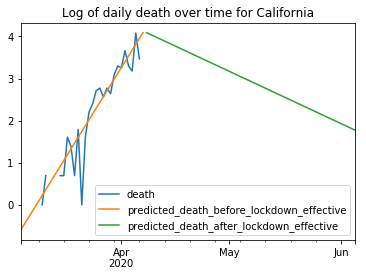

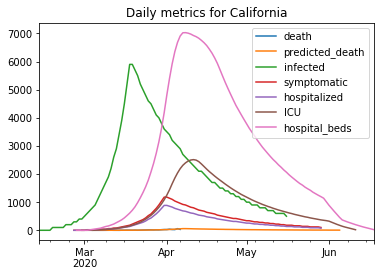

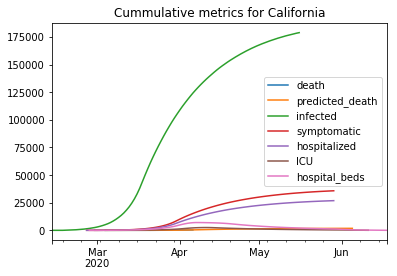

In [32]:
plot_metrics_by_state_US('California', lockdown_date='20200319')

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


Use default model due to no data
Use default model due to no data


/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


Use default model due to no data


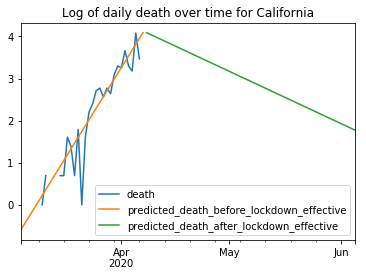

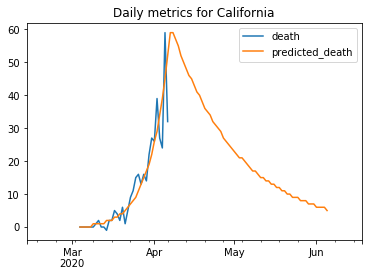

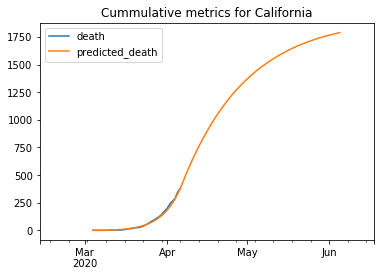

In [33]:
plot_metrics_by_state_US('California', lockdown_date='20200319', metrics = ['death', 'predicted_death'])

In [56]:
ny_daily, ny_cum = get_metrics_by_state_US('New York', lockdown_date='20200319')

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Use default model due to no data


/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Use default model due to no data


In [59]:
ny_cum.iloc[10:50]

,death,predicted_death,infected,symptomatic,hospitalized,hospital_beds,ICU
2020-03-04,NaN,NaN,22500.0,NaN,NaN,NaN,NaN
2020-03-05,NaN,NaN,29200.0,NaN,NaN,NaN,NaN
2020-03-06,NaN,NaN,37700.0,NaN,NaN,NaN,NaN
2020-03-07,NaN,NaN,48600.0,80.0,60.0,NaN,NaN
2020-03-08,NaN,NaN,62400.0,200.0,150.0,60.0,NaN
2020-03-09,NaN,NaN,80000.0,340.0,255.0,150.0,NaN
2020-03-10,NaN,NaN,102300.0,520.0,390.0,255.0,20.0
2020-03-11,NaN,NaN,130700.0,760.0,570.0,390.0,50.0
2020-03-12,NaN,NaN,166800.0,1080.0,810.0,570.0,85.0
2020-03-13,NaN,NaN,212700.0,1480.0,1110.0,810.0,130.0


In [57]:
ny_daily.iloc[30:50]

,death,predicted_death,infected,symptomatic,hospitalized,hospital_beds,ICU
2020-03-24,52.0,53.0,124500.0,5680.0,4260.0,13453.0,2844.0
2020-03-25,75.0,67.0,119600.0,7220.0,5415.0,17130.0,3623.0
2020-03-26,100.0,85.0,114900.0,9180.0,6885.0,21808.0,4607.0
2020-03-27,142.0,109.0,110400.0,11660.0,8745.0,27758.0,5862.0
2020-03-28,201.0,138.0,106100.0,14820.0,11115.0,35288.0,7458.0
2020-03-29,237.0,176.0,101900.0,18840.0,14130.0,44861.0,9487.0
2020-03-30,253.0,223.0,97900.0,23940.0,17955.0,57027.0,12062.0
2020-03-31,332.0,284.0,94100.0,30420.0,22815.0,72493.0,15332.0
2020-04-01,391.0,361.0,90400.0,30420.0,22815.0,92136.0,19490.0
2020-04-02,432.0,459.0,86900.0,29220.0,21915.0,110916.0,24774.0


/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Use default model due to no data
Use default model due to no data


/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Use default model due to no data


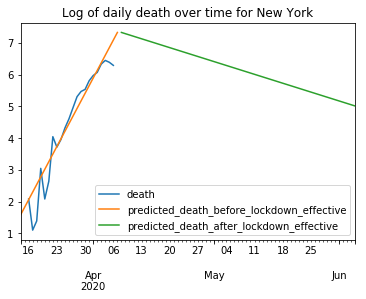

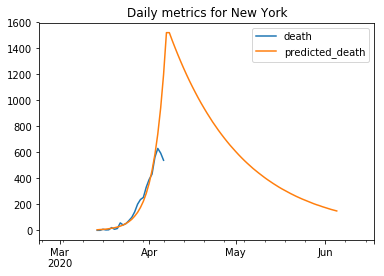

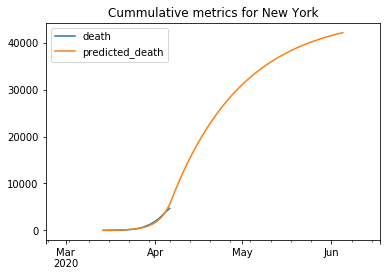

In [60]:
plot_metrics_by_state_US('New York', lockdown_date='20200319', metrics = ['death', 'predicted_death'])

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


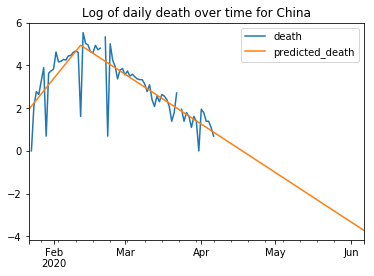

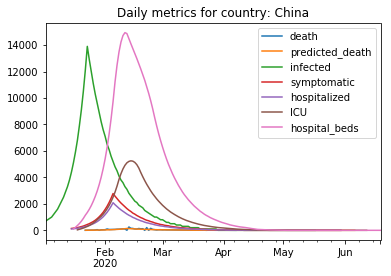

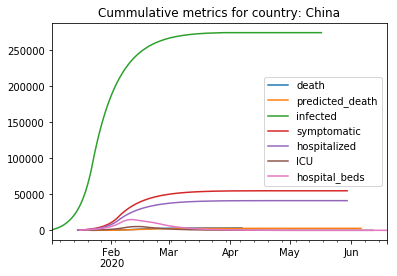

In [90]:
plot_metrics_by_country('China', lockdown_date='20200123')

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


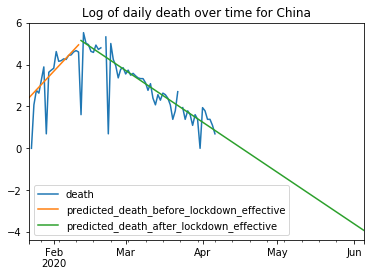

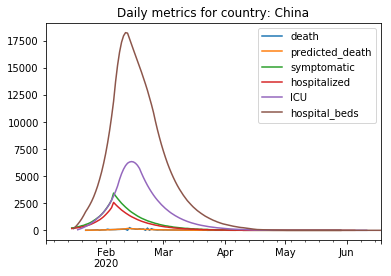

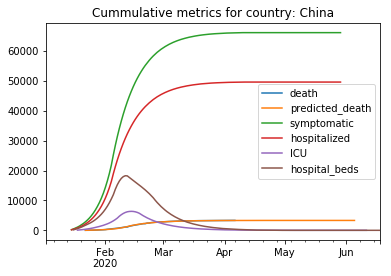

In [36]:
plot_metrics_by_country('China', lockdown_date='20200123',
                             metrics = ['death', 'predicted_death', 'symptomatic', 'hospitalized', 'ICU', 'hospital_beds'])

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


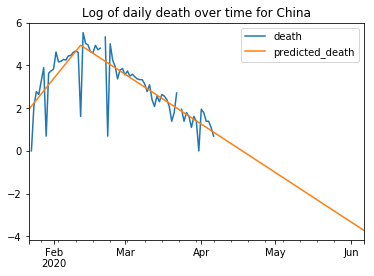

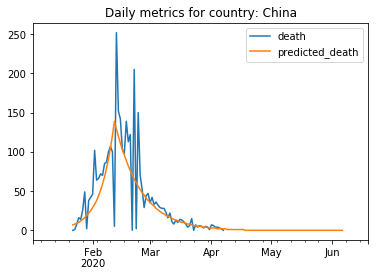

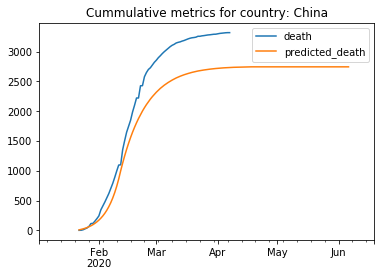

In [104]:
plot_metrics_by_country('China', lockdown_date='20200123',
                             metrics = ['death', 'predicted_death'])

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Use default second model due to no data
Use default second model due to no data


/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Use default second model due to no data


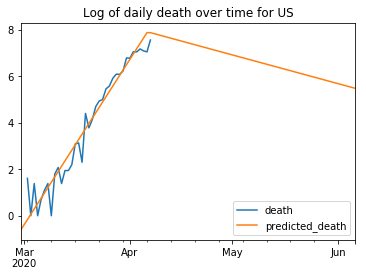

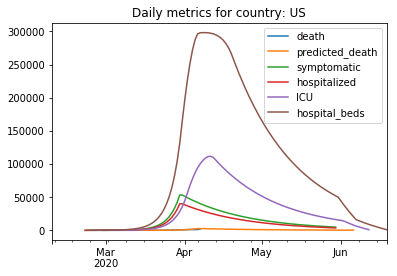

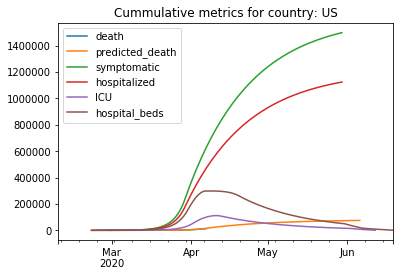

In [92]:
plot_metrics_by_country('US', lockdown_date='20200318',
                             metrics = ['death', 'predicted_death', 'symptomatic', 'hospitalized', 'ICU', 'hospital_beds'])

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Use default model due to no data
Use default model due to no data


/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Use default model due to no data


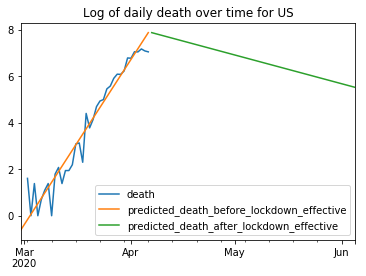

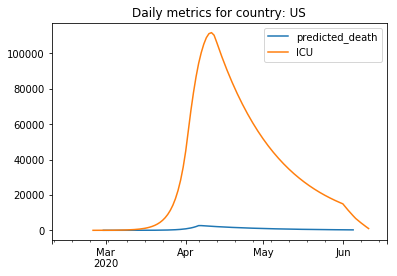

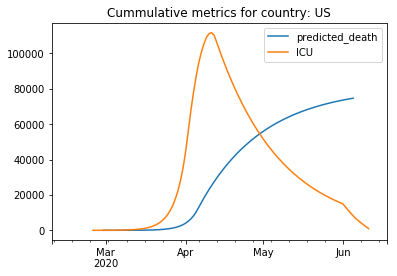

In [39]:
plot_metrics_by_country('US', lockdown_date='20200318',
                             metrics = ['predicted_death', 'ICU'])

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Use default model due to no data
Use default model due to no data


/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Use default model due to no data


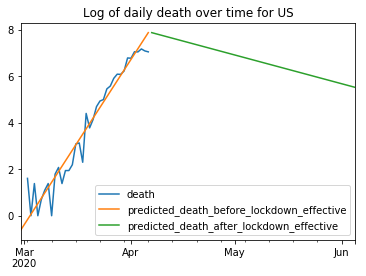

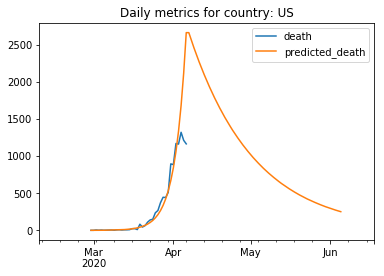

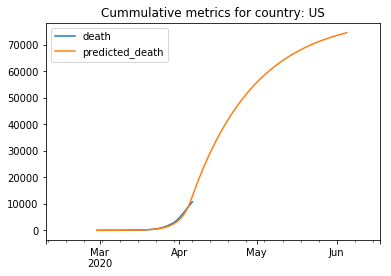

In [40]:
plot_metrics_by_country('US', lockdown_date='20200318',
                             metrics = ['death', 'predicted_death'])

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


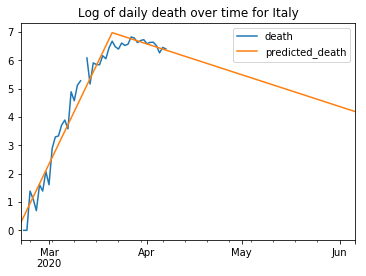

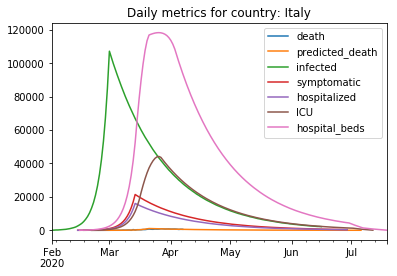

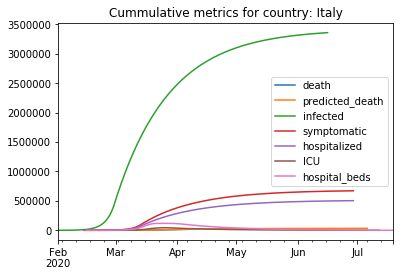

In [93]:
plot_metrics_by_country('Italy', lockdown_date='20200301', forecast_horizon=90) #Official date 09 March

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


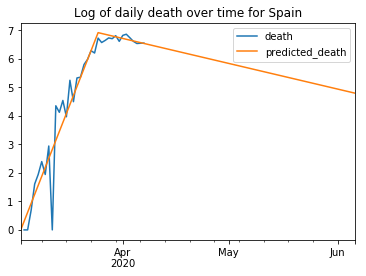

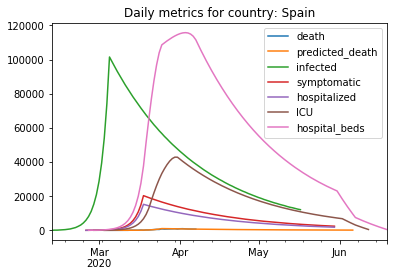

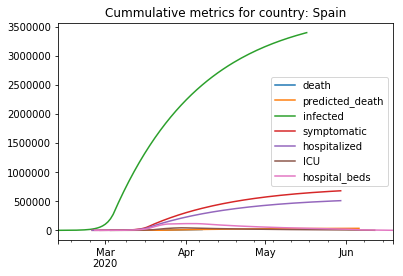

In [94]:
plot_metrics_by_country('Spain', lockdown_date='20200305') #official date 14 March

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Use default second model due to no data
Use default second model due to no data


/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Use default second model due to no data


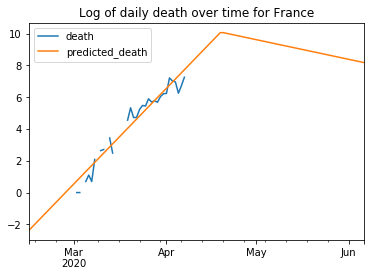

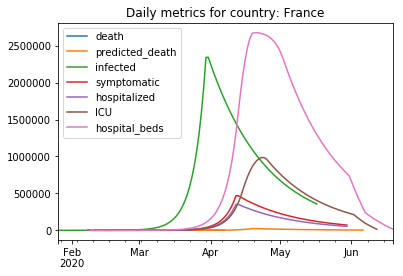

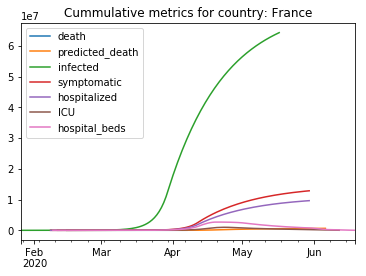

In [95]:
plot_metrics_by_country('France', lockdown_date='20200331')

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Use default second model due to no data
Use default second model due to no data


/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Use default second model due to no data


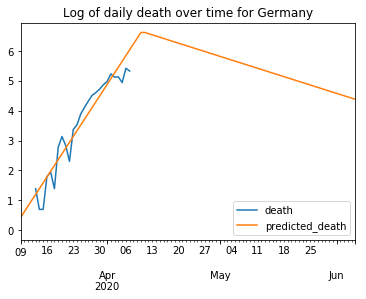

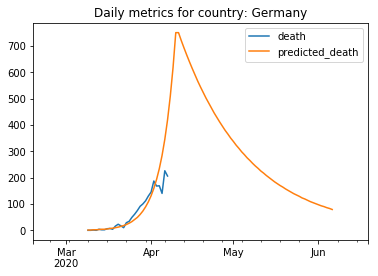

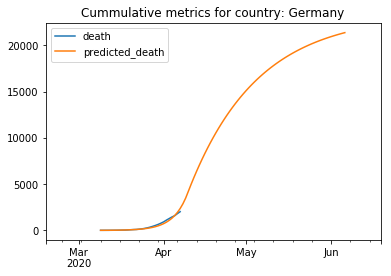

In [96]:
plot_metrics_by_country('Germany', lockdown_date='20200322', metrics=['death', 'predicted_death'])

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Use default second model due to no data
Use default second model due to no data


/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Use default second model due to no data


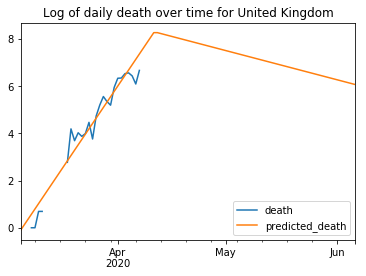

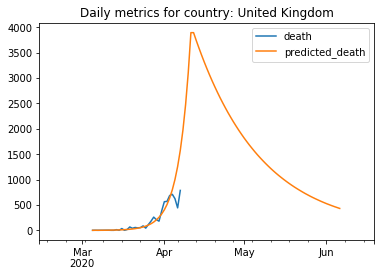

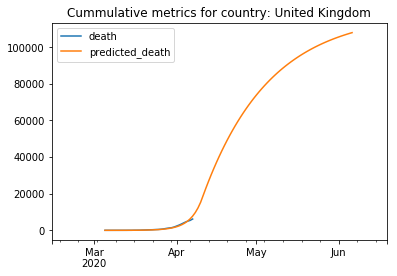

In [97]:
plot_metrics_by_country('United Kingdom', lockdown_date='20200323', metrics=['death', 'predicted_death'])

# The tails of two curves 21 days after lockdown

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


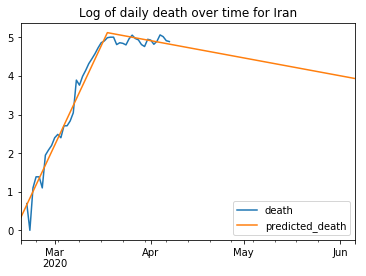

In [98]:
plot_log_death_new_by_country('Iran', lockdown_date='20200227') #Official date unclear

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


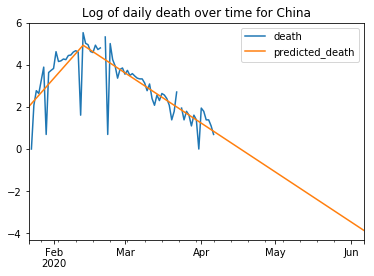

In [101]:
plot_log_death_new_by_country('China',  lockdown_date='20200124')

TODO: add function get county and provided all number
        improve the curve for after period

In [71]:
death_data = get_global_death_data()

In [49]:
death_data.query('Country=="US"')

,State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20
225,NaN,US,37.0902,-95.7129,0,0,0,0,0,0,...,2026,2467,2978,3873,4757,5926,7087,8407,9619,10783


In [77]:
len(death_data.Country.unique())

184

In [79]:
death_data.

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

In [80]:
death_data.Country.unique()[156
                           ]

'US'

In [105]:
death_data = get_US_death_data()

In [106]:
death_data.State.unique()

array(['American Samoa', 'Guam', 'Northern Mariana Islands',
       'Puerto Rico', 'Virgin Islands', 'Alabama', 'Alaska', 'Arizona',
       'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Diamond Princess',
       'Grand Princess'], dtype=object)

In [128]:
def get_lockdown_date_state_US(csv_file='data/lockdown_date_state_US.csv'):
    return pd.read_csv(csv_file)[['state', 'lockdown_date']].set_index('state')

In [129]:
lockdown_date_state_US = get_lockdown_date_state_US()

In [130]:
lockdown_date_state_US.loc['California'][0]

'2020/03/19'

In [131]:
pd.to_datetime(lockdown_date_state_US.loc['California'][0])

Timestamp('2020-03-19 00:00:00')

In [133]:
getattr(lockdown_date_state_US, 'Alaska')

AttributeError: 'DataFrame' object has no attribute 'Alaska'

In [1]:
import model_utils

InternalHashError: module '__main__' has no attribute '__file__'

While caching the body of `get_global_death_data()`, Streamlit encountered an
object of type `builtins.function`, which it does not know how to hash.

**In this specific case, it's very likely you found a Streamlit bug so please
[file a bug report here.]
(https://github.com/streamlit/streamlit/issues/new/choose)**

In the meantime, you can try bypassing this error by registering a custom
hash function via the `hash_funcs` keyword in @st.cache(). For example:

```
@st.cache(hash_funcs={builtins.function: my_hash_func})
def my_func(...):
    ...
```

If you don't know where the object of type `builtins.function` is coming
from, try looking at the hash chain below for an object that you do recognize,
then pass that to `hash_funcs` instead:

```
Object of type builtins.function: <function get_global_death_data at 0x1050daf28>
Object of type builtins.tuple: ('model_utils', 'get_global_death_data', <function get_global_death_data at 0x1050daf28>)
```

Please see the `hash_funcs` [documentation]
(https://streamlit.io/docs/advanced_caching.html)
for more details.
            

In [15]:
import pandas as pd
import datetime as dt
def put_model_params_logs(model_params, file='model_params_logs.csv'):
    pd.DataFrame(model_params, index=[dt.datetime.today()]).to_csv(file, mode='a', header=False)
from csv import writer
def append_model_params_2_logs(model_params, log_file='model_params_logs.csv'):
    # Open file in append mode
    with open(log_file, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(model_params)

In [17]:
scope = 'country'
local = 'US'
lockdown_date = '20200320'
model_params =(scope, local, lockdown_date)
append_model_params_2_logs(model_params, file_name='model_params_logs.csv')

In [19]:
[dt.datetime.today(),]+[3,3,3]

[datetime.datetime(2020, 4, 10, 15, 6, 5, 129965), 3, 3, 3]

In [21]:
model_params = [dt.datetime.today(), scope, local, lockdown_date, 
                mu.DEATH_RATE,
                mu.ICU_RATE,
                mu.HOSPITAL_RATE, 
                mu.SYMPTOM_RATE, 
                mu.INFECT_2_HOSPITAL_TIME, 
                mu.HOSPITAL_2_ICU_TIME, 
                mu.ICU_2_DEATH_TIME, 
                mu.ICU_2_RECOVER_TIME,
                mu.NOT_ICU_DISCHARGE_TIME]
append_model_params_2_logs(model_params)

NameError: name 'mu' is not defined

In [1]:
import pandas as pd

In [2]:
logs = pd.DataFrame.from_csv('model_params_logs.csv')

/Users/qtran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [3]:
logs

,scope,local,lockdown_date,DEATH_RATE,ICU_RATE,HOSPITAL_RATE,SYMPTOM_RATE,INFECT_2_HOSPITAL_TIME,HOSPITAL_2_ICU_TIME,ICU_2_DEATH_TIME,ICU_2_RECOVER_TIME,NOT_ICU_DISCHARGE_TIME
run_time,,,,,,,,,,,,
2020-04-10 15:36:12.766740,Country,US,2020-03-30,1.0,5.0,15.0,20.0,13,2,5,11,7
2020-04-10 15:41:50.528523,State,California,2020-03-19,2.8,5.0,15.0,20.0,13,2,5,11,7
